In this vignette I will show some of the geographic charactaristics of the ecoregions used in this study and how these are used to delineate major ecoregion groups

First, we will load the necessary packages to run the code

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#
# Author: Lewis Kunik - University of Utah
# Contact: lewis.kunik@utah.edu
#

#%%
#########################################
# Load packages
#########################################
# File system packages
import os  # operating system library
import sys
import glob
from pathlib import Path
import copy

# numerical/data management packages
import numpy as np
import xarray as xr 
import pandas as pd

# shapefile/geospatial packages
import geopandas as gpd
from shapely.geometry import mapping
from shapely.geometry import Point

# time and date packages
import time
from datetime import datetime as dt  # date time library
from datetime import timedelta

# Standard plotting packages
from matplotlib import pyplot as plt  # primary plotting module
from matplotlib.ticker import FuncFormatter as FFmt  # need this for formatting plot ticks

# Geospatial plotting packages
import cartopy.crs as ccrs  # cartopy is the best spatial plotting library i know
from cartopy.io import img_tiles  # cartopy's implementation of webtiles
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import matplotlib.colors as mcolors




Define any global filepaths and variables that will be needed throughout the script

In [2]:

#########################################
# Define Global Filepaths
#########################################

dat_basedir = '/uufs/chpc.utah.edu/common/home/lin-group19/ltk/SIF/SIF_IAV/data/'
EPA_ecoregion_dir = '/uufs/chpc.utah.edu/common/home/lin-group23/ltk/EPA/ecoregions/'
NLCD_dir = '/uufs/chpc.utah.edu/common/home/lin-group23/ltk/NLCD/'
elev_dir = '/uufs/chpc.utah.edu/common/home/lin-group23/ltk/SRTM/WUS/'
MAP_dir = '/uufs/chpc.utah.edu/common/home/lin-group23/ltk/GRIDMET/Precip/05d_1980-2010_mean/'

TCC_file = os.path.join(NLCD_dir, 'TreeCover/2019/NLCD_TCC_05d_WUS_2019.nc')
EPA_ecoregion_L2_file = os.path.join(EPA_ecoregion_dir, 'L2', 'WUS_cec_eco_l2.shp')
elev_file = os.path.join(elev_dir, 'SRTM_DEM_05d_WUS.nc')
MAP_file = os.path.join(MAP_dir, 'GRIDMET_TotalWYPrecip_WUS_1980-2010_mean.nc')

########################################
# Define Global Variables and constants
#########################################

# Define the averaging window definition for "annual" values
timing_label = 'FULL_YEAR' # options: "FULL_YEAR", "TOP_QUARTILE", "POST_PEAK_LAI", "PRE_PEAK_LAI"
dat_dir = os.path.join(dat_basedir, timing_label)  # directory where data files are stored, based on timing_label
analysis_years = range(2018, 2024)

## Define paths to data files
TROPOMI_SIF_file = glob.glob(f'{dat_dir}/TROPOMI_SIF*.nc')[0]

#########################################
# Set plotting parameters
#########################################

plt.rcParams.update({
   'axes.labelsize': 16,
   'axes.titlesize': 16,
   'xtick.labelsize': 16,
   'ytick.labelsize': 15,
   'legend.fontsize': 13,
})

# use Google Satellite imagery as basemap
tiler = img_tiles.GoogleTiles(style='satellite')
crs = tiler.crs # set crs of map tiler
alpha = 0.8  # transparency 0-1
transform = ccrs.PlateCarree()  # transform specifies the crs that the data is in

tiler_zoom = 7  # define a zoom level of detail
extent = [-125.3, -102.7, 29.7, 50.3]  # [minx, maxx, miny, maxy], bounds for map

### Load state boundaries
fn = shpreader.natural_earth(
   resolution='10m', category='cultural', 
   name='admin_1_states_provinces',
)
reader = shpreader.Reader(fn)
states = [x for x in reader.records() if x.attributes["admin"] == "United States of America"] # get all states in US
states_geom = cfeature.ShapelyFeature([x.geometry for x in states], ccrs.PlateCarree())

# matplotlib map plotting functions
def z_axis_formatter(x, pos, deci=2):
   '''Format ticks to format with deci number of decimals'''

   return f'{x:.{deci}f}'



Define any functions that will be needed throughout the script

In [3]:
#########################################
# Define Global Functions
#########################################

# -----------------------------------------------------------------------
# Function to load xarray data and set CRS
# -----------------------------------------------------------------------
def load_xr(dat_xr_file, varname = None):
    if varname is not None:
        dat_xr = xr.open_dataset(dat_xr_file, decode_coords='all').sortby(['x', 'y'], ascending = True)[varname]
    else:
        dat_xr = xr.open_dataset(dat_xr_file, decode_coords='all').sortby(['x', 'y'], ascending = True)
    dat_xr.rio.write_crs(4326, inplace=True)
    return dat_xr

Load all the relevant  datasets, including:
    -TROPOMI SIF
    -NASA SRTM elevation data
    -National Land Cover Database (NLCD) Tree Canopy Cover data
    -GRIDMET historical avg mean annual precipitation (1980-2010)
Note that all datasets have been spatially regridded to 0.05° grid resolution

In [4]:

###### Load all the files as xarray dataarrays
TROPOMI_SIF_xr = load_xr(TROPOMI_SIF_file, 'sifdc') # TROPOMI SIF

# Load tree canopy cover, elevation and mean annual precipitation
TCC_xr = xr.open_dataset(TCC_file, decode_coords='all').rename({'lon':'x', 'lat':'y'}).sortby(['x', 'y'], ascending = True).squeeze('band')['tree_canopy_cover'] # NLCD Tree Cover
elev_xr = xr.open_dataset(elev_file, decode_coords='all').rename({'lon':'x', 'lat':'y'}).sortby(['x', 'y'], ascending = True).squeeze('band')['elevation'] # SRTM Elevation
MAP_xr = xr.open_dataset(MAP_file, decode_coords='all').sortby(['x', 'y'], ascending = True)['mean'] # GRIDMET Mean Annual Precipitation

# Mask out the unused data which are not "ENF" type
TCC_xr_mask = TCC_xr.where(~np.isnan(TROPOMI_SIF_xr))
elev_xr_mask = elev_xr.where(~np.isnan(TROPOMI_SIF_xr))
MAP_xr_mask = MAP_xr.where(~np.isnan(TROPOMI_SIF_xr))


### Visualize the data

Let's plot some maps of the datasets just to understand their patterns

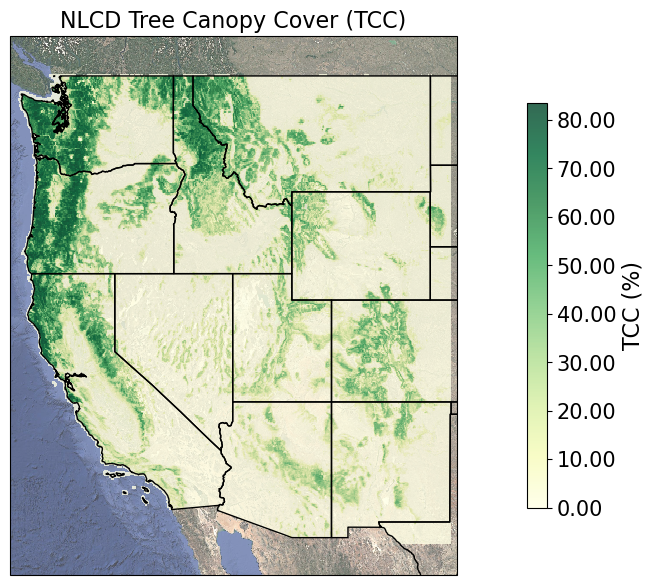

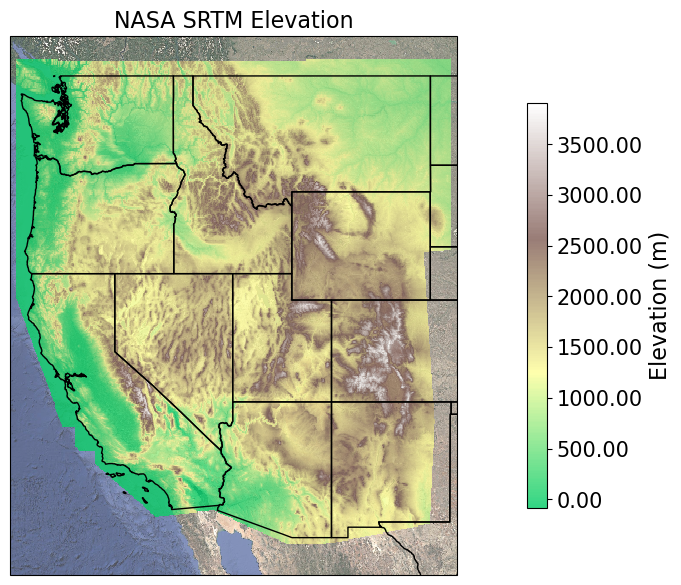

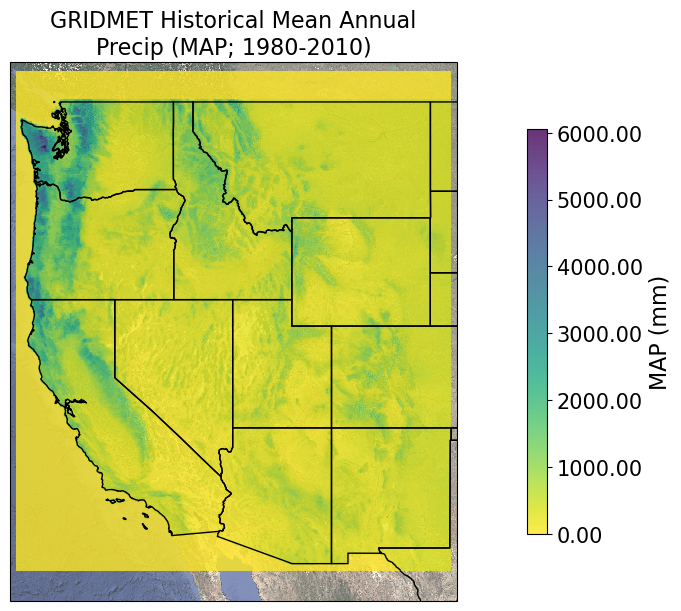

In [5]:
def plot_dataarray_map(dat_da, plotTitle, zax_label, plot_min=None, plot_max=None, cmap='inferno_r'):
    if plot_min is None:
        plot_min = np.nanmin(dat_da.values)
    if plot_max is None:
        plot_max = np.nanmax(dat_da.values)
    fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize=(9, 7)) # establish the figure, axes
    # Set extent of map before adding base img
    ax.set_extent(extent, crs=ccrs.PlateCarree())  # PlateCarree is default lat/lon
    ax.add_image(tiler, tiler_zoom, interpolation='none', alpha=0.7) # Add base image

    # add state boundaries to the map
    ax.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)

    dat_da.plot(ax=ax, transform=transform, alpha=alpha, 
                    cmap=cmap, vmin = plot_min, vmax = plot_max,
                        cbar_kwargs={'orientation': 'vertical',
                                            'pad': 0.1,
                                            'label': zax_label,
                                            'shrink': 0.75,
                                            'format': FFmt(z_axis_formatter)})

    plt.title(plotTitle) # set axis title
    plt.show()



# Plot NLCD Tree Canopy Cover
plot_dataarray_map(TCC_xr, 'NLCD Tree Canopy Cover (TCC)', 
    'TCC (%)', cmap='YlGn')

# Plot NASA SRTM Elevation
# Custom terrain colormap for the elevation map - land only
terrain_colors = plt.cm.terrain(np.linspace(0.25, 1, 256))  # Skip the blue/water colors at the start
custom_terrain_cmap = mcolors.LinearSegmentedColormap.from_list('custom_terrain', terrain_colors)
plot_dataarray_map(elev_xr, 'NASA SRTM Elevation', 
    'Elevation (m)', cmap=custom_terrain_cmap)

# Plot GRIDMET Historical Mean Annual Precipitation
plot_dataarray_map(MAP_xr, 'GRIDMET Historical Mean Annual\nPrecip (MAP; 1980-2010)', 
    'MAP (mm)', cmap='viridis_r')


### EPA Level II Ecoregions

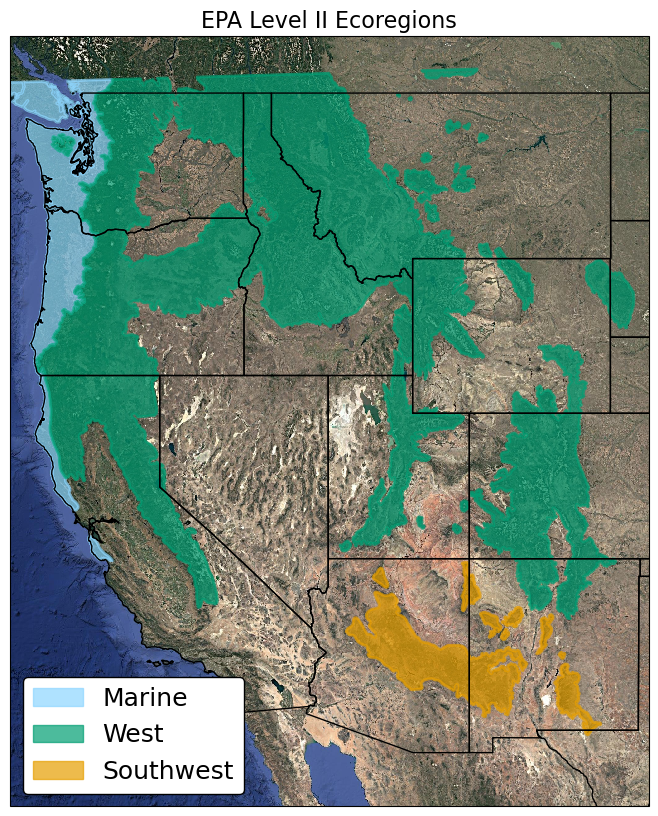

In [8]:


# Load EPA L2 Ecoregion file and define individual region geometries
ecoregion_l2_gdf = gpd.read_file(EPA_ecoregion_L2_file)

Region1_name = 'MARINE WEST COAST FOREST'
Region2_name = 'WESTERN CORDILLERA'
Region3_name = 'UPPER GILA MOUNTAINS'
ecoregion_l2_gdf_Region1 = ecoregion_l2_gdf[ecoregion_l2_gdf.NA_L2NAME == Region1_name]
ecoregion_l3_geom_Region1 = ecoregion_l2_gdf_Region1.geometry

ecoregion_l2_gdf_Region2 = ecoregion_l2_gdf[ecoregion_l2_gdf.NA_L2NAME == Region2_name]
ecoregion_l3_geom_Region2 = ecoregion_l2_gdf_Region2.geometry

ecoregion_l2_gdf_Region3 = ecoregion_l2_gdf[ecoregion_l2_gdf.NA_L2NAME == Region3_name]
ecoregion_l3_geom_Region3 = ecoregion_l2_gdf_Region3.geometry


region_names = ['Southwest', 'West', 'Marine']
# List of region geometries and names
region_geoms = [
    ecoregion_l3_geom_Region3, ecoregion_l3_geom_Region2, ecoregion_l3_geom_Region1
]

#### Plot a map of ecoregions
figsize = (12, 10)  # width, height in inches
fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize=figsize)

# Set extent of map before adding base img
ax.set_extent(extent, crs=ccrs.PlateCarree())  # PlateCarree is default lat/lon
ax.add_image(tiler, tiler_zoom, interpolation='none', alpha=1) # Add base image

alpha = 0.75  # transparency 0-1

# Plot numbered text boxes at centroids of each region
import matplotlib.patches as mpatches
ax.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)
# for geom_region in region_geoms_Pacific_group:
ax.add_geometries(ecoregion_l3_geom_Region1, crs=transform, facecolor="#8ED6FF", edgecolor='#8ED6FF', linewidth=2, zorder=1, alpha = 0.7)
ax.add_geometries(ecoregion_l3_geom_Region2, crs=transform, facecolor="#009E73", edgecolor='#009E73', linewidth=2, zorder=1, alpha = 0.7)
ax.add_geometries(ecoregion_l3_geom_Region3, crs=transform, facecolor="#E69F00", edgecolor='#E69F00', linewidth=2, zorder=1, alpha = 0.7)


# Create custom legend patches
legend_patches = [
    mpatches.Patch(facecolor="#8ED6FF", edgecolor='#8ED6FF', alpha=0.7, label='Marine'),
    mpatches.Patch(facecolor="#009E73", edgecolor='#009E73', alpha=0.7, label='West'),
    mpatches.Patch(facecolor="#E69F00", edgecolor='#E69F00', alpha=0.7, label='Southwest'),
]

plt.xlabel('lon', fontsize=10)
plt.ylabel('lat', fontsize=10)
plt.title('EPA Level II Ecoregions') # set axis title
ax.legend(handles=legend_patches, loc='lower left', fontsize=18, frameon=True, facecolor='white', edgecolor='black', framealpha=1)
plt.show()

### Distribution of Tree Canopy Cover by ecoregion


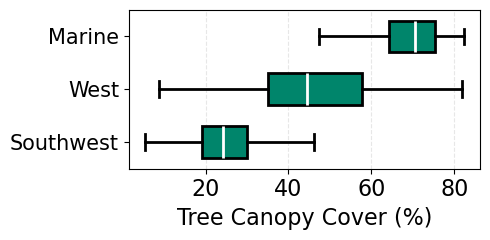

In [9]:
#%%
# Create figure for TCC distributions across ecoregions
fig, ax = plt.subplots(figsize=(5, 2.5))

# Collect TCC data for each region
tcc_data_by_region = []
region_labels = []

for i, (region_geom, region_name) in enumerate(zip(region_geoms, region_names)):
    # Clip TCC data to the current ecoregion
    TCC_clipped = TCC_xr_mask.rio.write_crs(4326).rio.clip(region_geom, drop=True)
    
    # Extract values and remove NaNs
    tcc_values = TCC_clipped.values.flatten()
    tcc_values = tcc_values[~np.isnan(tcc_values)]
    
    if len(tcc_values) > 0:
        tcc_data_by_region.append(tcc_values)
        region_labels.append(region_name)

# Sort regions by median TCC value
TCC_medians = [np.median(data) for data in tcc_data_by_region]

# Create box-whisker plot with vertical orientation
bp = ax.boxplot(tcc_data_by_region, tick_labels=region_labels, patch_artist=True,
                showfliers=False, widths=0.6, vert=False, 
                boxprops=dict(linewidth=2), whiskerprops=dict(linewidth=2),
                capprops=dict(linewidth=2), medianprops=dict(linewidth=2))

# Set median line color to white
for median in bp['medians']:
    median.set_color('white')
# Customize box colors
for patch in bp['boxes']:
    patch.set_facecolor('#00856B')

# No rotation needed for y-axis labels
ax.set_yticklabels(region_labels)

# Labels and title (swapped x and y)
ax.set_xlabel('Tree Canopy Cover (%)', fontsize=16)

# Add grid for easier reading
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()


### Distribution of Elevation by ecoregion


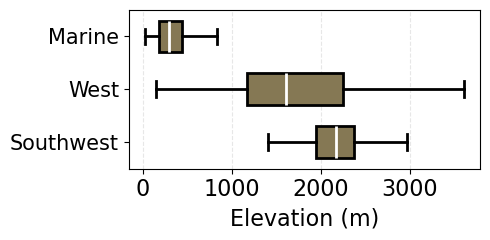

In [10]:

# Create figure for Elevation distributions across ecoregions
fig, ax = plt.subplots(figsize=(5, 2.5))

# Collect elevation data for each region
elev_data_by_region = []
region_labels = []

for i, (region_geom, region_name) in enumerate(zip(region_geoms, region_names)):
    # Clip elevation data to the current ecoregion
    elev_clipped = elev_xr_mask.rio.write_crs(4326).rio.clip(region_geom, drop=True)
    
    # Extract values and remove NaNs
    elev_values = elev_clipped.values.flatten()
    elev_values = elev_values[~np.isnan(elev_values)]
    
    if len(elev_values) > 0:
        elev_data_by_region.append(elev_values)
        region_labels.append(region_name)

# Sort regions by median elevation value
elev_medians = [np.median(data) for data in elev_data_by_region]

# Create box-whisker plot with vertical orientation
bp = ax.boxplot(elev_data_by_region, tick_labels=region_labels, patch_artist=True,
                showfliers=False, widths=0.6, vert=False, 
                boxprops=dict(linewidth=2), whiskerprops=dict(linewidth=2),
                capprops=dict(linewidth=2), medianprops=dict(linewidth=2))

# Set median line color to white
for median in bp['medians']:
    median.set_color('white')
# Customize box colors
for patch in bp['boxes']:
    patch.set_facecolor('#857854')

# No rotation needed for y-axis labels
ax.set_yticklabels(region_labels)

# Labels and title (swapped x and y)
ax.set_xlabel('Elevation (m)', fontsize=16)
# ax.set_title('Distribution of Elevation by Ecoregion', fontsize=18, fontweight='bold')

# Add grid for easier reading
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()



### Distribution of Mean Annual Precipitation (MAP) by ecoregion

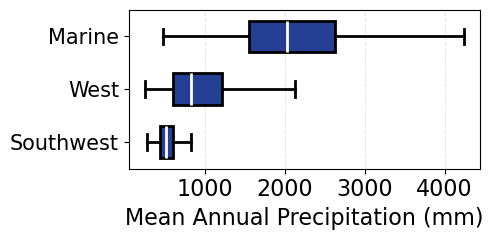

In [11]:
# Create figure for MAP distributions across ecoregions
fig, ax = plt.subplots(figsize=(5, 2.5))

# Collect MAP data for each region
map_data_by_region = []
region_labels = []

for i, (region_geom, region_name) in enumerate(zip(region_geoms, region_names)):
    # Clip MAP data to the current ecoregion
    MAP_clipped = MAP_xr_mask.rio.write_crs(4326).rio.clip(region_geom, drop=True)
    
    # Extract values and remove NaNs
    map_values = MAP_clipped.values.flatten()
    map_values = map_values[~np.isnan(map_values)]
    
    if len(map_values) > 0:
        map_data_by_region.append(map_values)
        region_labels.append(region_name)

# Sort regions by median MAP value
map_medians = [np.median(data) for data in map_data_by_region]

# Create box-whisker plot with vertical orientation
bp = ax.boxplot(map_data_by_region, tick_labels=region_labels, patch_artist=True,
                showfliers=False, widths=0.6, vert=False, 
                boxprops=dict(linewidth=2), whiskerprops=dict(linewidth=2),
                capprops=dict(linewidth=2), medianprops=dict(linewidth=2))

# Set median line color to white
for median in bp['medians']:
    median.set_color('white')
# Customize box colors
for patch in bp['boxes']:
    patch.set_facecolor('#253F94')


# No rotation needed for y-axis labels
ax.set_yticklabels(region_labels)

# Labels and title (swapped x and y)
ax.set_xlabel('Mean Annual Precipitation (mm)', fontsize=16)

# Add grid for easier reading
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()